In [1]:
import pandas as pd
from cartopy import crs as ccrs
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
# import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean.cm as cmo
import cmocean
import gsw
from geopy import distance
import xesmf as xe
# import sectionate
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
import seaborn as sns
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
import matplotlib as mpl

dpi = 200
mpl.rcParams['figure.dpi'] = dpi
sns.set_context("notebook")

In [2]:
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
from Streamfunctions import *

In [3]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmol kg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmol kg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmol kg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'thetao':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'deg C','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [4]:
expt_colors = dict(); expt_colors["control"] = "#2f74b3"; expt_colors["forced"] = "#cc415a"


In [5]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/" + x

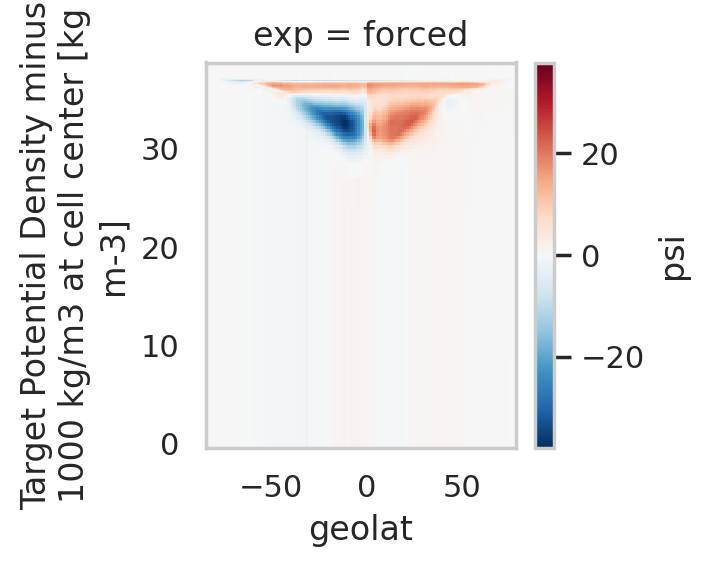

In [6]:
ds_psi = xr.open_dataset(datadir(f"CM4xp125_isopycnal_streamfunction_since_init.nc"))
ds_psi =ds_psi["psi"]

psi_mean =  ds_psi.sel(time = slice("1850", None)).mean("time")

fig, ax = plt.subplots(figsize = (2.5, 2.5))
psi_mean.isel(exp = 0).plot(x = "geolat", y = "sigma2_l", ax = ax)

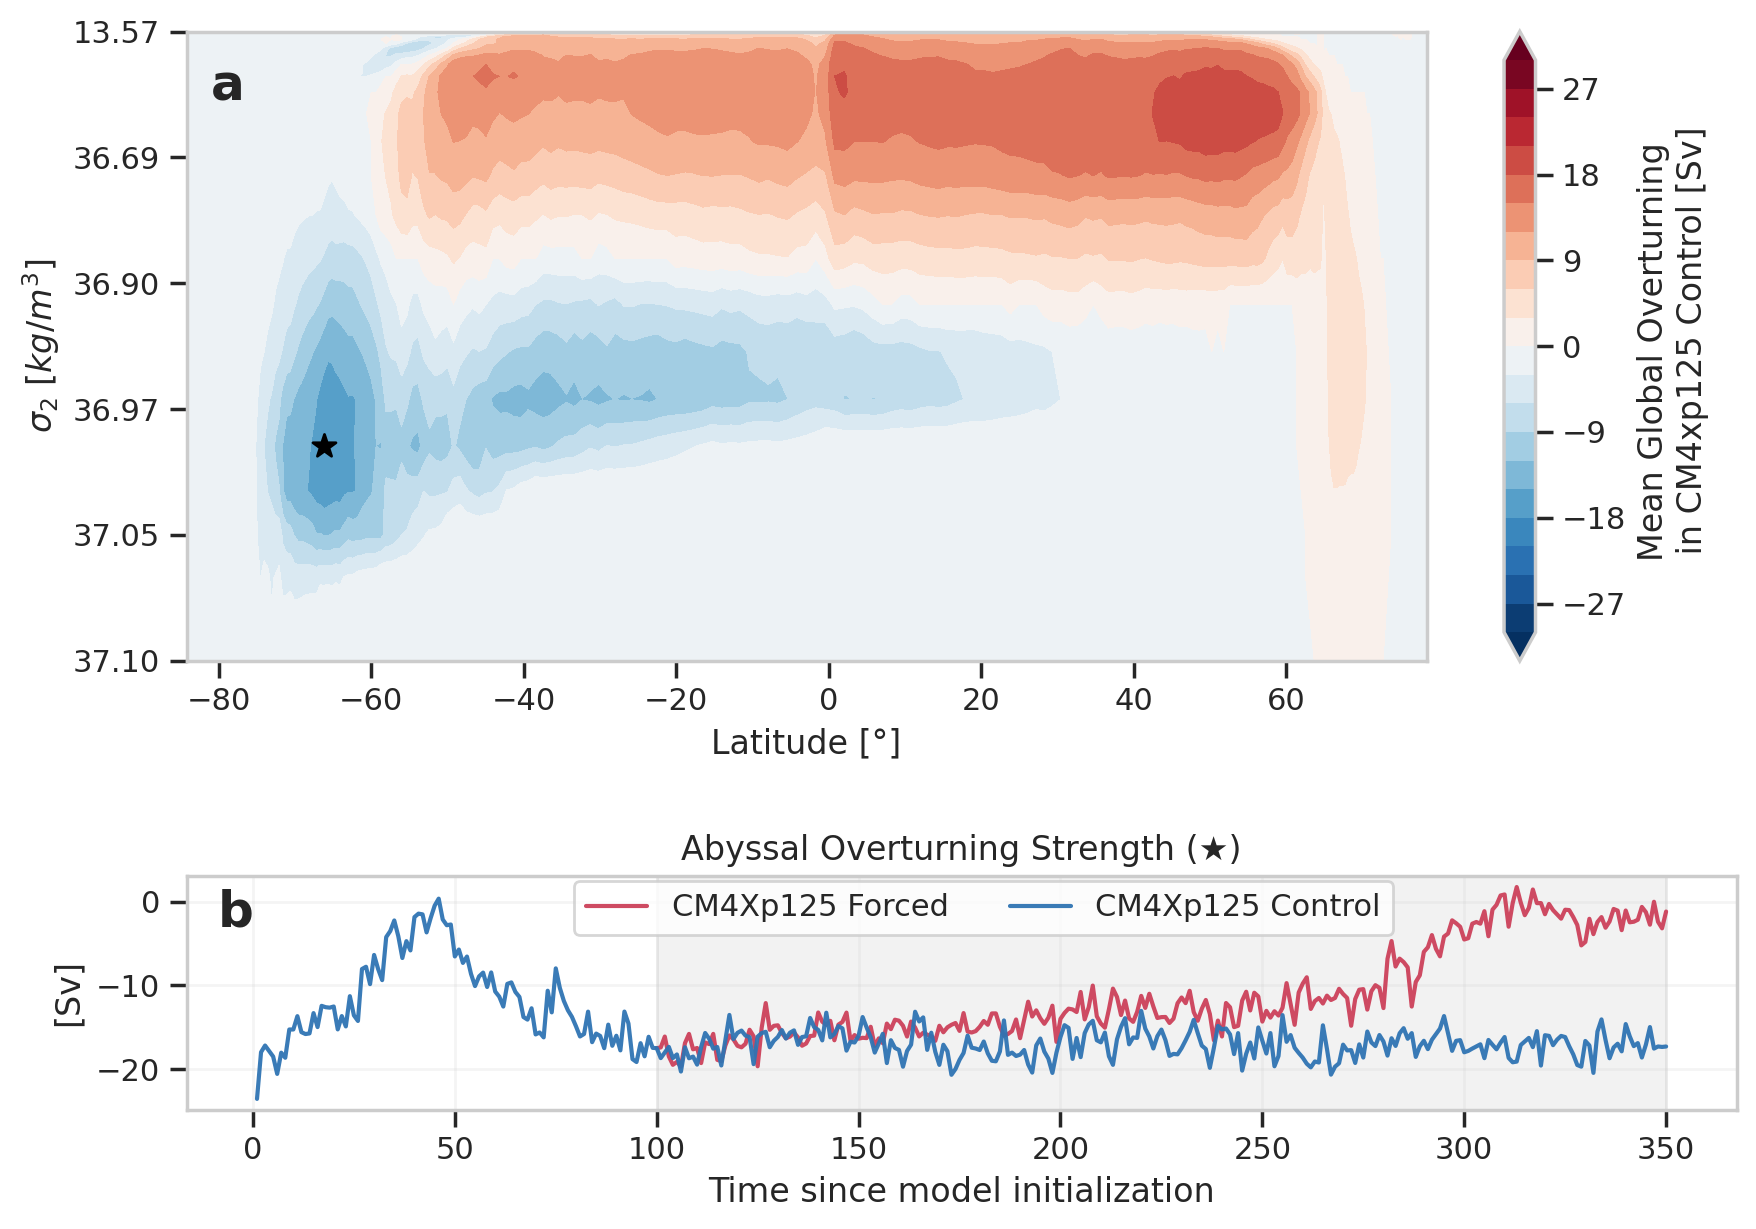

In [44]:
# Prepare data
eps = 1e-8
ds_psi_init = 1 * ds_psi 
ds_psi_init.coords["time"] = ds_psi_init["time_since_init"]
ds_psi_yearly = ds_psi_init.groupby("time.year").mean("time")

psi_mean = ds_psi.sel(time=slice("1850", None)).mean("time")

locs = find_min_locations(psi_mean.sel(exp="control", sigma2_l=slice(36.5, None)))

# Create figure and axes
fig, ax_rev = plt.subplots(2, 1, figsize=(10, 7), height_ratios=[2.7, 1])
ax = [ax_rev[1], ax_rev[0]]

# Configure all axes
for a in ax: 
    a.grid(alpha=0.2)
    a.tick_params(bottom=True, left=True)
    
# Plot time series
ds_psi_yearly.sel(year = slice(100, None)).sel(exp="forced").sel(**locs).plot(
    ax=ax[0], c=expt_colors["forced"], lw=1.5, alpha=0.95, label="CM4Xp125 Forced")
ds_psi_yearly.sel(exp="control").sel(**locs).plot(
    ax=ax[0], c=expt_colors["control"], lw=1.5, alpha=0.95, label="CM4Xp125 Control")

ax[0].axvspan(100, 350, color='grey', alpha=0.1, zorder=0)
ax[0].set_ylabel("[Sv]")
ax[0].set_title("Abyssal Overturning Strength (★)")
ax[0].set_xlabel("Time since model initialization")
ax[0].legend(markerscale=0.5, ncols=2, loc=(0.25, 0.75), frameon=True)

# Process and plot overturning data
psi_crop = psi_mean.sel(sigma2_l=slice(5, 37.1))
psi_crop = psi_crop.where(np.abs(psi_crop) > 1).fillna(0.0)
levels = np.arange(-30, 30 + eps, 3)
transformation_power = 100 

plot_isopycnal_overturning(
    fig, ax[1], 
    psi_crop.sel(exp="control"),
    streamfunction_var='psi',
    density_dim='sigma2_l',
    lat_dim='geolat',
    power=transformation_power,
    levels=levels, 
    clabel = "Mean Global Overturning \n in CM4xp125 Control [Sv]"
)

# Finalize bottom plot
ax[1].set_ylabel(r"$\sigma_2$ $[kg/m^3]$")
ax[1].set_xlabel("Latitude [°]")
transformed_density = density_transform(psi_crop["sigma2_l"], transformation_power)
minimum_transformed = transformed_density.sel(sigma2_l=locs["sigma2_l"])
ax[1].invert_yaxis()
ax[1].scatter(psi_crop.geolat.sel(yq=locs["yq"]), 
              minimum_transformed, c="k", marker="*", s=75)

# Configure all axes and add labels
subplot_labels = ['a', 'b']
for i, a in enumerate(ax_rev):
    a.grid(alpha=0.2)
    a.tick_params(bottom=True, left=True)
    # Add subplot label in the top left corner
    a.text(0.02, 0.95, f'{subplot_labels[i]}', transform=a.transAxes, 
           fontsize=18, fontweight='bold', va='top')

# Adjust spacing and layout
fig.subplots_adjust(hspace=0.5)


fig.savefig(plotsdir(f"paper_figures/1.global_overturning.png"), 
        bbox_inches = "tight", dpi = dpi)

In [45]:
ds_psi_yearly = ds_psi_init.groupby("time.year").mean("time")

locs = find_min_locations(ds_psi_yearly.sel(exp="control", sigma2_l=slice(36.5, None)), fixed_dim="year")

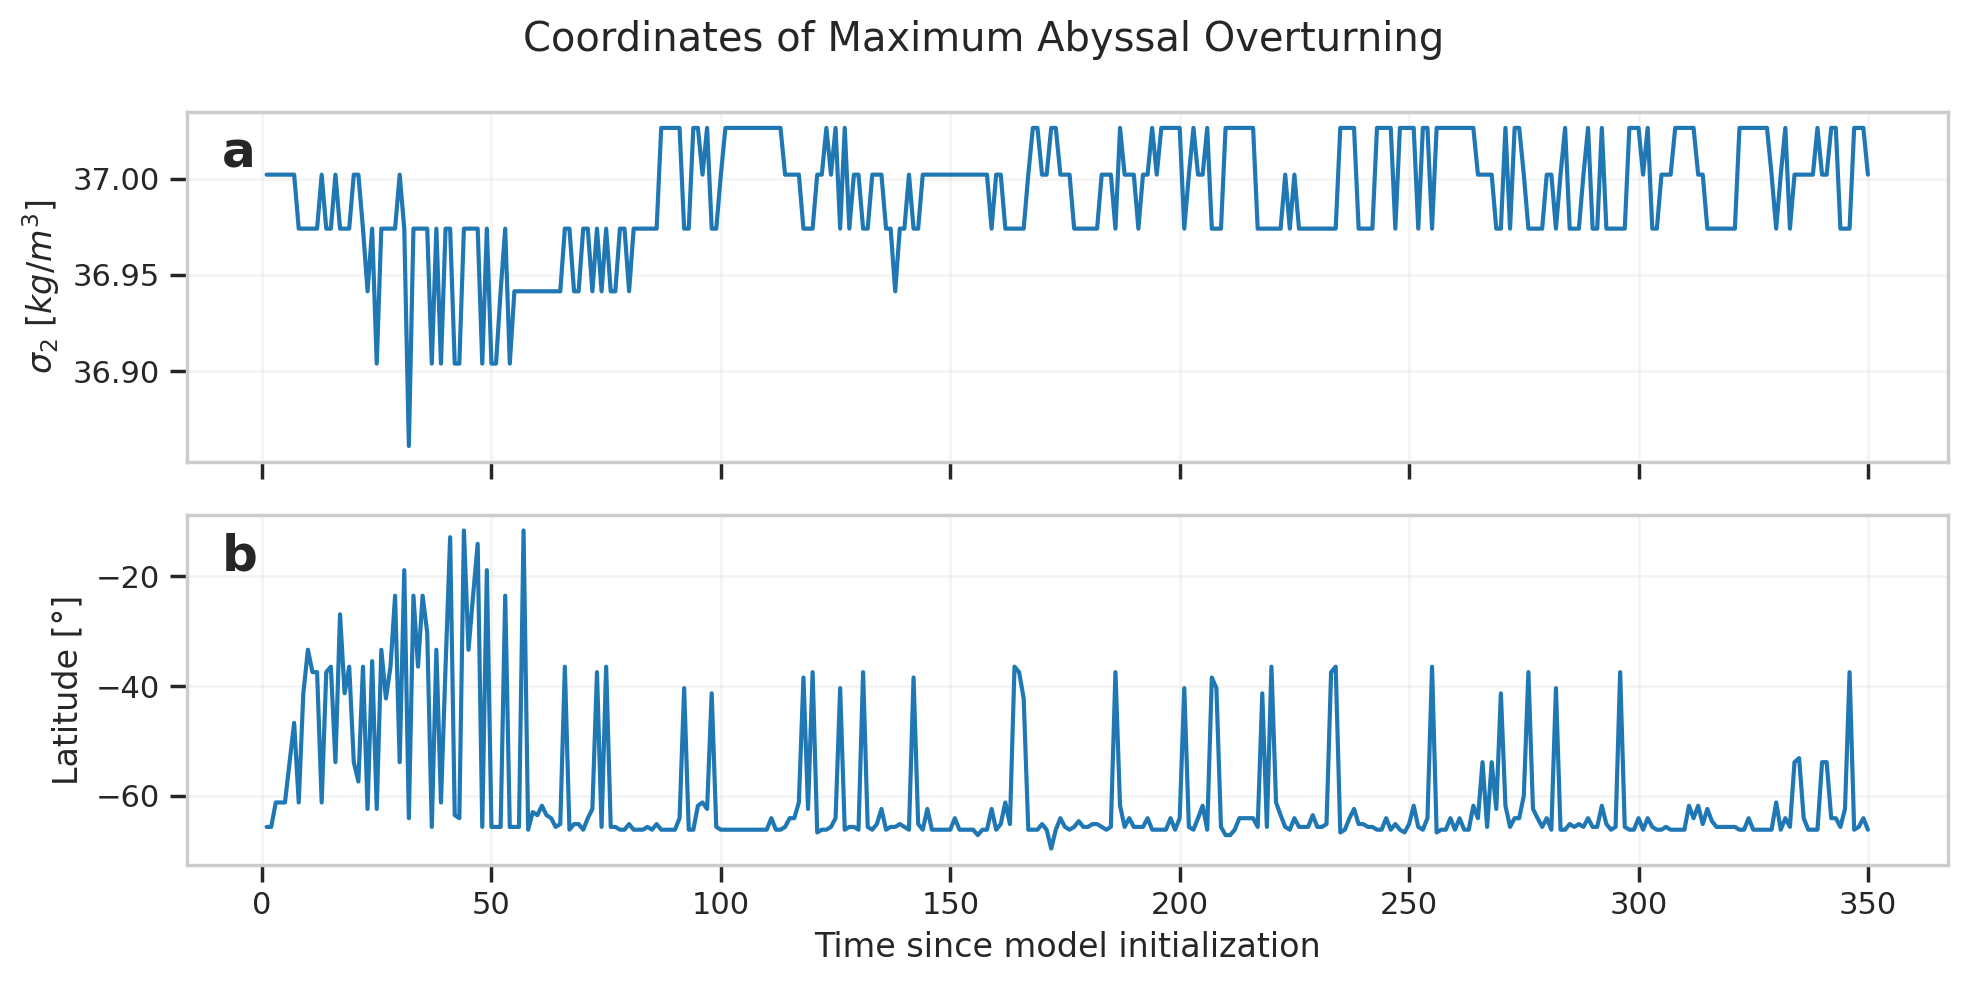

In [54]:
fig, ax = plt.subplots(2, 1, figsize = (10, 5), sharex = True)

ds_psi_yearly.geolat.sel(yq = locs.yq).compute().plot(ax = ax[1])
locs.sigma2_l.compute().plot(ax = ax[0])

# Configure all axes and add labels
subplot_labels = ['a', 'b']
for i, a in enumerate(ax):
    a.grid(alpha=0.2)
    a.set_title("")
    a.set_xlabel("")
    a.tick_params(bottom=True, left=True)
    # Add subplot label in the top left corner
    a.text(0.02, 0.95, f'{subplot_labels[i]}', transform=a.transAxes, 
           fontsize=18, fontweight='bold', va='top')

ax[1].set_xlabel("Time since model initialization")

ax[0].set_ylabel(r"$\sigma_2$ $[kg/m^3]$")
ax[1].set_ylabel("Latitude [°]")

fig.suptitle("Coordinates of Maximum Abyssal Overturning")
fig.tight_layout()

fig.savefig(plotsdir(f"paper_figures/1.global_overturning_locations.png"), 
        bbox_inches = "tight", dpi = dpi)
